In [1]:
# !pip install --no-deps 'timm-0.1.26-py3-none-any.whl' > /dev/null
# !pip install omegaconf

In [2]:
!pip uninstall -y timm

Found existing installation: timm 0.1.26
Uninstalling timm-0.1.26:
  Successfully uninstalled timm-0.1.26


In [3]:
!pip install timm==0.3.2

  Using cached timm-0.3.2-py3-none-any.whl (244 kB)


In [4]:
!pip install --no-deps 'timm-0.1.26-py3-none-any.whl' > /dev/null

In [1]:
import sys
sys.path.insert(0, "timm-efficientdet-pytorch")
# sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "effdet")
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pickle
from effdet_old import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet_old.efficientdet import HeadNet
from ensemble_boxes import *


from matplotlib import pyplot as plt
SEED = 42
import gc
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
label_codes = {
"Pedestrian": 0,
"Biker": 1,
"Car": 2,
"Bus": 3,
"Skater": 4,
"Cart": 5
}
label_colors = {
0: (1,0,0),
1:(0,1,0),
2: (0,0,1),
 3: (1,1,0),
4:(0,1,1),
5:(1,1,1)
}

In [7]:
# with open('train_dataset.df', 'wb') as f:
#     pickle.dump(train_dataset.df, f)
# with open('train_dataset.df', 'rb') as f:
#     df = pickle.load(f)

In [143]:
transforms =  A.Compose([
                A.RandomSizedCrop(min_max_height=(1024, 1024), height=512, width=512, p=1),
#             A.RandomCrop(512, 512),
#             A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)



In [147]:
class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        if image.shape[0]<1024:
            image = image[:image.shape[0],:image.shape[0]]
            image = cv2.resize(image, (1024,1024))
        
        image /= 255.0
        if self.transforms:
            sample = transforms(image=image)
            image = sample['image']
        return image,image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

45992 coupa_video0_2319
coupa_video0_2319


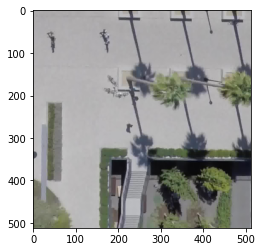

In [129]:
k = random.randint(1,50000)
image, image_id = dataset[k]
print(k,image_id)
print(dataset.image_ids[k])
plt.imshow(dataset[k][0].permute(1,2,0))

In [127]:
dataset.image_ids[20000]

'deathCircle_video3_7277'

In [77]:
image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')])

In [ ]:
image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')])

225948

In [148]:
DATA_ROOT_PATH = '/mnt/r4/aliev/stanford_voc/VOC2012/JPEGImages'
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [6]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d1')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 6
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()


net = load_net('effdet1_loss_1_42_batch12_state_dict.pt')

In [160]:
def make_predictions(images, score_threshold=0.12):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        print("shape of input: ",images.shape)
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            labels = det[i].detach().cpu().numpy()[:,5]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes]
            })
    return [predictions],det

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.12, skip_box_thr=0.12, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [prediction[image_index]['labels'].tolist()  for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [11]:
images[0].shape

torch.Size([3, 512, 512])

In [135]:
dataset.image_ids[157394]

'hyang_video3_1329'

19754
shape of input:  torch.Size([1, 3, 512, 512])
[0.45469737 0.30404329 0.29090795 0.28279084 0.2716592  0.26233974
 0.23122999 0.22709005 0.22648236 0.18878296 0.18584476 0.18107077
 0.17401603 0.16911745 0.15821755 0.15426892 0.15097027 0.15037605
 0.13868475 0.12040219]


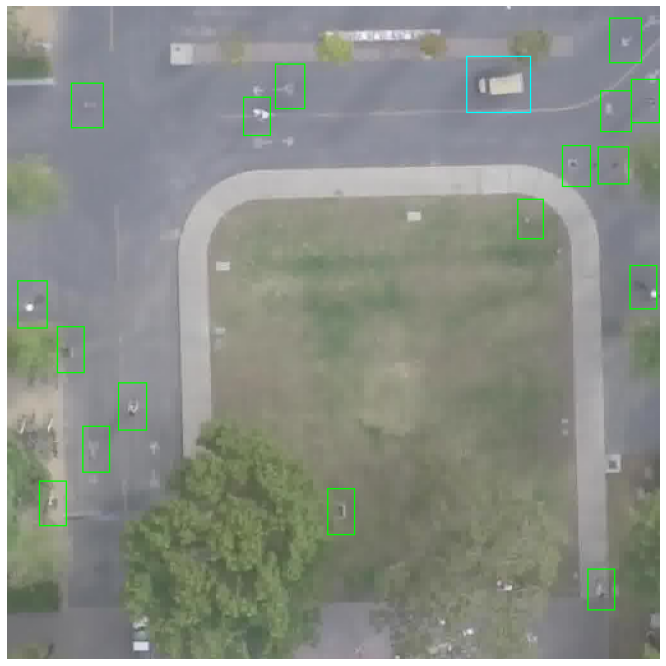

In [161]:

# for j, (images,image_ids) in enumerate(data_loader):
#     print(image_ids)
#     break
k = random.randint(1,200000)
print(k)
images, image_id = dataset[k]
images = (images,)
predictions,det = make_predictions(images,0.01)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
print(scores)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

for box,label in zip(boxes,labels):
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), label_colors[label], 1)
    
ax.set_axis_off()
ax.imshow(sample)
